In [2]:
library(tidyverse)

library(rpart)
library(rpart.plot)

library(caret)
library(vip)
library(pdp)

## 의사결정나무
- **전처리 필요없음**
- **결측값 데체 필요없음**
- 예측 정확도를 달성하지 못할 수 있음
- 깊은 나무는 높은 분산과 낮은 편향을 갖고, 얕은 나무는 높은 편향과 낮은 분산을 가짐

### 분할
- CART : 재귀 이진 분할
- 분할의 목적은 노드의 유사성을 최소화 하는 것
- 데이터가 두 영역으로 분할되고, 분할 프로세스가 두 영역 각각에서 반복
- 정지기준에 도달할 때 까지 계속 (하나의 변수가 여러번 사용 가능)

### 깊이
- 너무 복잡하면 과적합, 일반화 성능 저하
- 트리의 깊이와 균형을 달성
- 균형을 찾기 위해서
    1. 조기중단
    2. 가지치기

### 조기종료
- 나무의 성장을 명시적으로 제한
- 나무의 성장을 제한하는 방법
        1. 나무 깊이를 특정 수준으로 제한
        2. 노드에서 허용되는 최소 관측값 수를 제한 (나무 깊이를 제한할 때 특정 깊이 후에 분할을 중지

- 트리가 얕을수록 예측에서 분산이 적음
- 최소 터미널 노드 크기를 제한할 때 (최소 10개의 관측값) 너무 적은 데이터 포인트를 포함하는 중간 노드를 분할하지 않음

### 가지치기
- 의사결정나무의 깊이를 명시적으로 지정하는 것의 대안
- 크고 복잡한 트리를 성장시킨다음, 다시 정리하여 최적의 하위트리를 찾는 것
- 라쏘회귀와 연관 (가장 낮은 페널티 오차가 있는 트리를 탐색)
- 페널티(alpha)가 크면 트리가 작아짐

### ```rpart()```

In [3]:
ames <- ames <- AmesHousing::make_ames()
index <- sample(1:dim(ames)[1], 0.7*dim(ames)[1])
ames_train <- ames[index,]
ames_test <- ames[-index,]

In [4]:
ames_dt1 <- rpart(
    formula = Sale_Price ~ .,
    data = ames_train,
    method = "anova"
)

In [5]:
ames_dt1

n= 2051 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 2051 1.296431e+13 180529.10  
   2) Overall_Qual=Very_Poor,Poor,Fair,Below_Average,Average,Above_Average,Good 1721 3.932635e+12 156198.90  
     4) Neighborhood=North_Ames,Old_Town,Edwards,Sawyer,Mitchell,Brookside,Iowa_DOT_and_Rail_Road,South_and_West_of_Iowa_State_University,Meadow_Village,Briardale,Northpark_Villa,Blueste,Landmark 1027 1.328588e+12 132292.60  
       8) Overall_Qual=Very_Poor,Poor,Fair,Below_Average 198 1.684957e+11  99222.77 *
       9) Overall_Qual=Average,Above_Average,Good 829 8.918393e+11 140191.00  
        18) First_Flr_SF< 1207.5 618 3.444860e+11 131596.10 *
        19) First_Flr_SF>=1207.5 211 3.679876e+11 165364.60 *
     5) Neighborhood=College_Creek,Somerset,Northridge_Heights,Gilbert,Northwest_Ames,Sawyer_West,Crawford,Timberland,Northridge,Stone_Brook,Clear_Creek,Bloomington_Heights,Veenker,Green_Hills 694 1.148529e+12 191576.10  
      10) Gr_Liv_Area< 1477 298 2.485647e

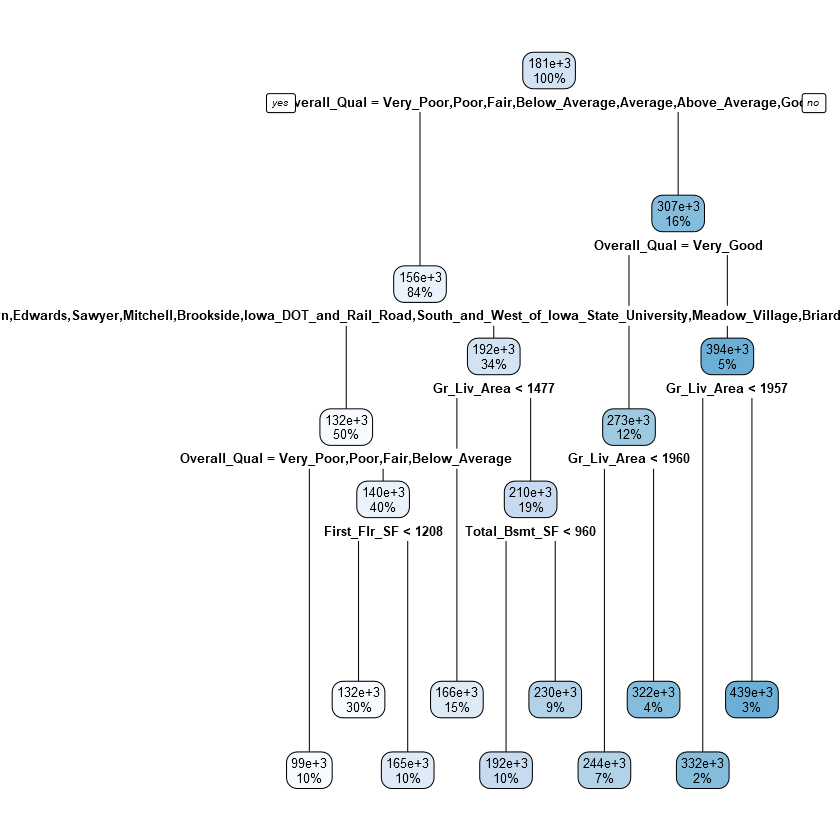

In [6]:
rpart.plot(ames_dt1)

#### - ```rpart()```는 비용 복잡도의 범위를 자동으로 적용

- 각 alpha값에 대한 오류를 비교하기 위해 10-folds CV 수행

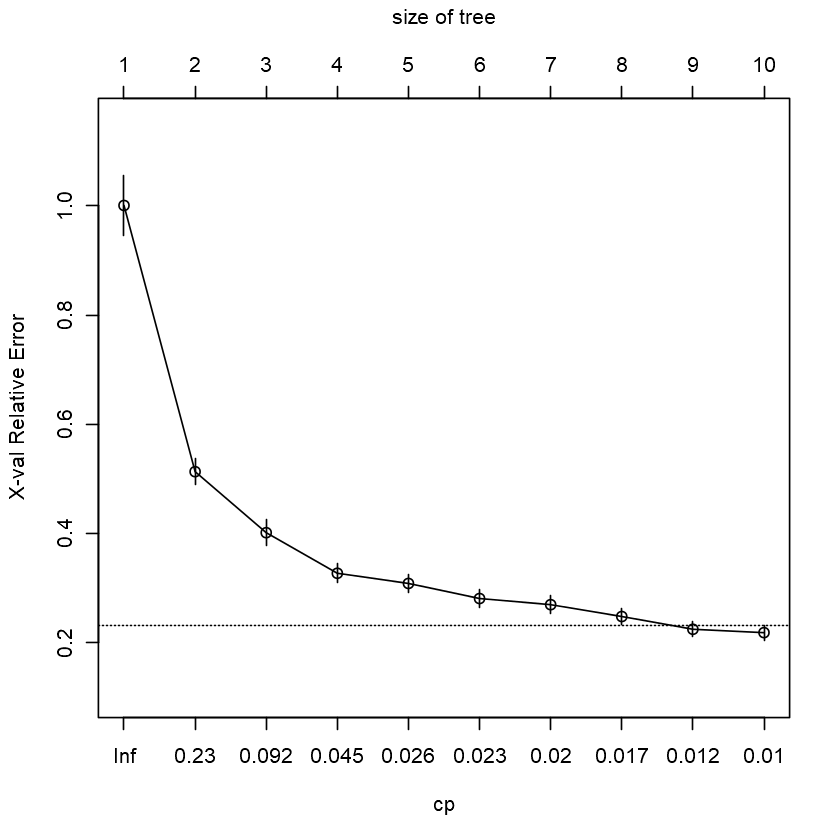

In [7]:
plotcp(ames_dt1)

- 하단 x축 : cp값 (비용 복잡도)
- 상단 x축 : 터미널 노드 수 (트리 크기)
- y축 : CV error, 상대 교차검증 오차
- cp값이 작을수록 트리가 커짐


### 1-SE 규칙
#### - 최소 CV오차의 1 표준편차 이내에서 가장 작은 트리를 대신 사용하는 것이 일반적
#### - 1-SE 규칙을 사용하면 9-11의 트리크기가 최적의 교차검증 결과를 제공

#### 9의 트리크기를 사용하여 트리르 선택
#### - ```cp = 0```을 설정하여, ``` rpart()```가 전체 트리를 생성도록 설정
#### - 페널티가 없으면 완전히 자란 나무

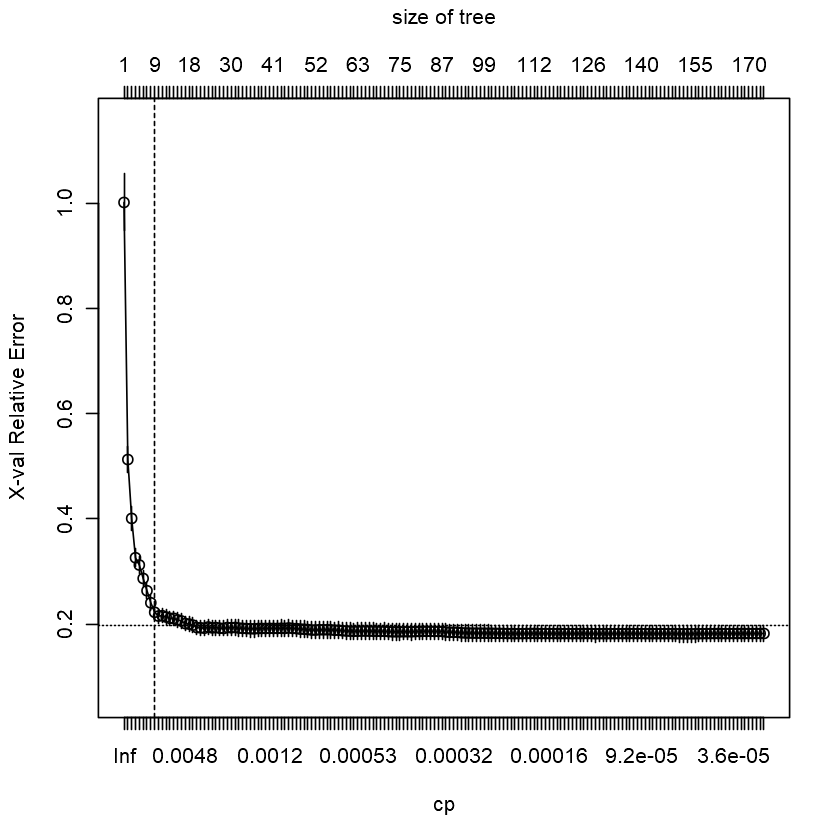

In [13]:
ames_dt2 <- rpart(
    formula = Sale_Price ~ .,
    data    = ames_train,
    method  = "anova", 
    control = list(cp = 0, xval = 9)
)

plotcp(ames_dt2)
abline(v = 9, lty = "dashed")

#### - 9개의 노드 이후 트리가 더 깊어짐에 따라 CV error 감소폭이 작아지는 것을 확인 
#### (cp를 늘려도 더이상 개선이 되지 않는다)
#### - 가지치기를 해도, 낮은 CV error값을 얻을 수 있음을 확인

In [14]:
ames_dt1$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.48840074,0,1.0000000,1.0008289,0.05417188
2,0.11227119,1,0.5115993,0.5130176,0.02424779
3,0.07509238,2,0.3993281,0.4012069,0.02365970
4,0.02667550,3,0.3242357,0.3268457,0.01709656
5,0.02535087,4,0.2975602,0.3082171,0.01686353
6,0.02069164,5,0.2722093,0.2805745,0.01572900
7,0.02011109,6,0.2515177,0.2693080,0.01616706
8,0.01383535,7,0.2314066,0.2476004,0.01504839
9,0.01075994,8,0.2175712,0.2242451,0.01411815
10,0.01000000,9,0.2068113,0.2180859,0.01365860


- 9개의 분할 수 (10개의 노드 수)가 최소의 CV error을 가짐을 확인

### 튜닝

In [15]:
ames_dt3 <- train(
    Sale_Price ~ .,
    data = ames_train,
    method = "rpart",
    trControl = trainControl(method = "cv", number = 10),
    tuneLength = 20
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


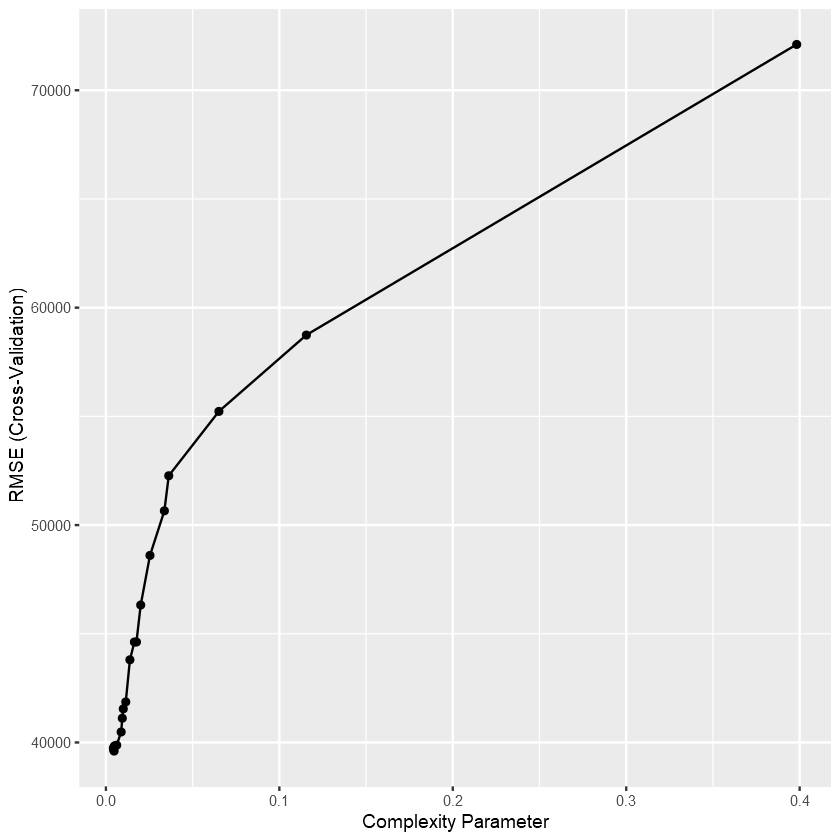

In [16]:
ggplot(ames_dt3)

### 변수 중요도
- 각 분할에서 손실함수(에 : SSE)의 감소에 기여한 각 변수를 표시
- **모든 분할에 대한 손실함수의 총 감소가 합산되어 변수 중요도로 사용**

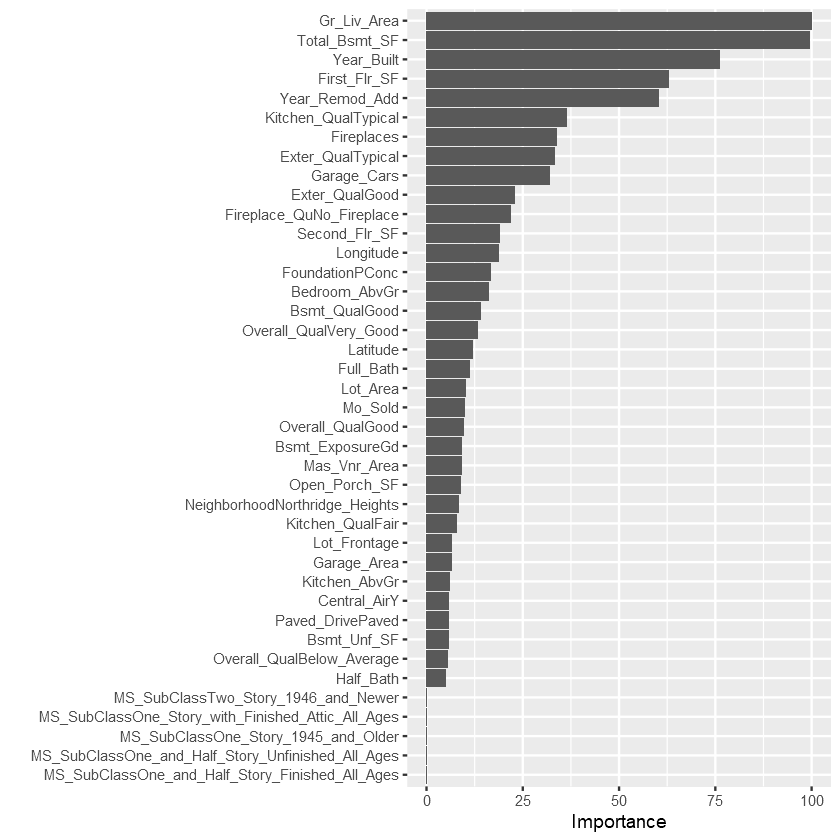

In [17]:
vip(ames_dt3, num_features = 40, bar = F)

In [18]:
pred <- predict(ames_dt3, newdata = ames_test)

In [28]:
mse <- mean((ames_test$Sale_Price - pred)^2) ; mse

[1] 1821495949

### PDP

In [29]:
p1 <- partial(ames_dt3, pred.var = "Gr_Liv_Area") %>% autoplot()
p2 <- partial(ames_dt3, pred.var = "Year_Built") %>% autoplot()
p3 <- partial(ames_dt3, pred.var = c("Gr_Liv_Area", "Year_Built")) %>% 
  plotPartial(levelplot = FALSE, zlab = "yhat", drape = TRUE, 
              colorkey = TRUE, screen = list(z = -20, x = -60))

Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."
Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."


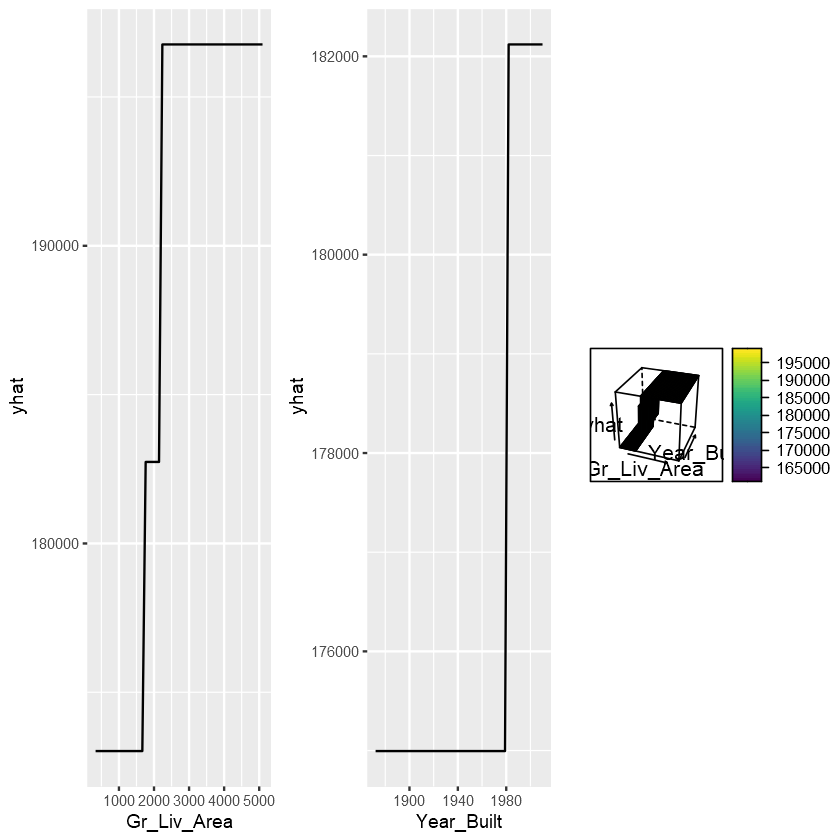

In [30]:
gridExtra::grid.arrange(p1, p2, p3, ncol = 3)